# Adaptive stopping in a Bandit problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from compare_agents import MultipleAgentsComparator

from rlberry.agents.torch import DQNAgent, PPOAgent, A2CAgent
from rlberry.agents import RSUCBVIAgent
import pandas as pd

from rlberry.envs.bandits import BernoulliBandit
from rlberry.wrappers import WriterWrapper
from rlberry.agents.bandits import (
    IndexAgent,
    RandomizedAgent,
    makeBoundedIMEDIndex,
    makeBoundedMOSSIndex,
    makeBoundedNPTSIndex,
    makeBoundedUCBIndex,
    makeETCIndex,
)



We wish to reproduce the results in https://rlberry.readthedocs.io/en/latest/auto_examples/demo_bandits/plot_compare_index_bandits.html#sphx-glr-auto-examples-demo-bandits-plot-compare-index-bandits-py


## Problem setting

In [2]:
# Parameters of the problem
means = np.array([0.6, 0.6, 0.6, 0.9])  # means of the arms
A = len(means)
T = 2000  # Horizon

# Construction of the experiment

env_ctor = BernoulliBandit
env_kwargs = {"p": means}


class UCBAgent(IndexAgent):
    name = "UCB"

    def __init__(self, env, **kwargs):
        index, _ = makeBoundedUCBIndex()
        IndexAgent.__init__(self, env, index, **kwargs)
        self.env = WriterWrapper(
            self.env, self.writer, write_scalar="reward"
        )
    


class ETCAgent(IndexAgent):
    name = "ETC"

    def __init__(self, env, m=20, **kwargs):
        index, _ = makeETCIndex(A, m)
        IndexAgent.__init__(self, env, index, **kwargs)
        self.env = WriterWrapper(
            self.env, self.writer, write_scalar="action_and_reward"
        )

        
class MOSSAgent(IndexAgent):
    name = "MOSS"

    def __init__(self, env, **kwargs):
        index, _ = makeBoundedMOSSIndex(T, A)
        IndexAgent.__init__(self, env, index, **kwargs)
        self.env = WriterWrapper(
            self.env, self.writer, write_scalar="action_and_reward"
        )


class IMEDAgent(IndexAgent):
    name = "IMED"

    def __init__(self, env, **kwargs):
        index, tracker_params = makeBoundedIMEDIndex()
        IndexAgent.__init__(self, env, index, tracker_params=tracker_params, **kwargs)
        self.env = WriterWrapper(
            self.env, self.writer, write_scalar="reward"
        )

class NPTSAgent(IndexAgent):
    name = "NPTS"

    def __init__(self, env, **kwargs):
        index, tracker_params = makeBoundedNPTSIndex()
        IndexAgent.__init__(self, env, index, tracker_params=tracker_params, **kwargs)
        self.env = WriterWrapper(
            self.env, self.writer, write_scalar="reward"
        )


Agents_class = [
    MOSSAgent,
    IMEDAgent,
    NPTSAgent,
    UCBAgent,
    ETCAgent
]

managers = [
    (Agent,
        dict(
        train_env=(env_ctor, env_kwargs),
        fit_budget=T,
        parallelization="process",
        mp_context="fork")
    )
    for Agent in Agents_class
]


## Adastop algorithm

In [3]:
# we want to be able to see a difference of 5 and the std is around 10
n = 10
K = 10
B=10000
alpha = 0.05

In [4]:

n_managers = len(managers)
print('With these parameters, we have a maximum of {} fits done for each agent'.format(n*K))
print('Number of comparisons is {}'.format(n_managers*(n_managers-1)/2))

With these parameters, we have a maximum of 100 fits done for each agent
Number of comparisons is 10.0


let us now compare all the different algorithm

In [5]:
from rlberry.utils.logging import set_level
set_level('ERROR')

In [6]:
class Comparator(MultipleAgentsComparator):
    def __init__(self, **kwargs):
        MultipleAgentsComparator.__init__(self, **kwargs)
        
    def _get_evals(self, manager):
        """
        Compute the cumulative reward.
        """
        eval_values = []
        for idx in  manager.get_writer_data():
            df = manager.get_writer_data()[idx]
            eval_values.append(np.sum(np.max(means)-df.loc[df['tag']=='reward', 'value']))
        return eval_values

In [7]:
comparator  = Comparator(n=n, K=K, B=B, alpha=alpha, n_evaluations = 10, beta=0.01)

comparator.compare(managers)

print(comparator.decisions)
print(comparator.n_iters)

Step 0
reject
reject
Step 1
reject
Step 2
reject
reject
reject
reject
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
{'[0 1]': 'larger', '[0 2]': 'larger', '[0 3]': 'smaller', '[0 4]': 'larger', '[1 2]': 'equal', '[1 3]': 'smaller', '[1 4]': 'equal', '[2 3]': 'smaller', '[2 4]': 'equal', '[3 4]': 'larger'}
{'Agent 0': 30, 'Agent 1': 100, 'Agent 2': 30, 'Agent 3': 30, 'Agent 4': 100}


In [12]:
comparator.n_iters

{'Agent 0': 30, 'Agent 1': 100, 'Agent 2': 30, 'Agent 3': 30, 'Agent 4': 100}

We reject the comparisons (1,3), (0,1), (0,2) , (2,3) and (0,3). Let us check graphically that this makes sense

In [8]:
comparator.eval_values

[array([39., 17.,  5., 33., 36., 47., 29., 13., 42., 38., 23., 13., 13.,
        28., 19., 10., 24., 53., 45., 51., 23., 31., 18., 32., 18., 38.,
        29., 65., 24., 32.]),
 array([ 3.50000000e+01,  7.00000000e+00,  2.00000000e+00,  3.00000000e+00,
         2.00000000e+01,  2.00000000e+01,  3.90000000e+01,  3.50000000e+01,
        -2.20000000e+01,  3.90000000e+01,  1.00000000e+01,  5.10000000e+01,
         2.80000000e+01,  1.70000000e+01,  3.60000000e+01,  3.30000000e+01,
         2.10000000e+01,  6.00000000e+00,  1.00000000e+01, -5.00000000e+00,
         1.00000000e+00,  7.00000000e+00,  1.30000000e+01,  1.40000000e+01,
         1.10000000e+01,  2.20000000e+01,  2.00000000e+00,  3.10000000e+01,
         3.00000000e+00,  2.60000000e+01,  3.40000000e+01,  2.70000000e+01,
         3.30000000e+01,  5.00000000e+00,  1.80000000e+01,  1.20000000e+01,
         2.70000000e+01,  2.60000000e+01,  1.50000000e+01,  4.10000000e+01,
         2.40000000e+01,  3.50000000e+01,  3.00000000e+00,  3.90

In [9]:
id_sort = np.argsort(comparator.mean_eval_values)
Z = [ comparator.eval_values[f] for f in id_sort]

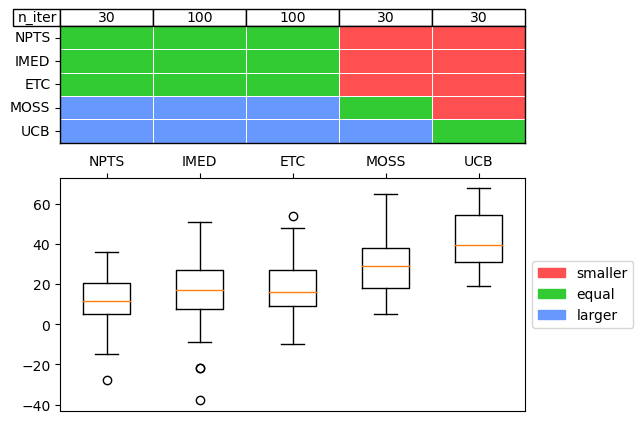

In [10]:
comparator.plot_results(['MOSS','IMED','NPTS','UCB','ETC'])